# Telecom


## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

Описание данных: 
Таблица telecom.contract
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- ЗaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Таблица personal
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Таблица telecom.internet
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Таблица telecom.phone
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

## Загрузка данных

In [43]:
!pip install phik
!pip install -U scikit-learn
from sqlalchemy import create_engine 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from phik import phik_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from torch.utils.data import Dataset, DataLoader
#from skorch.callbacks import EpochScoring, EarlyStopping
import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [44]:
RANDOM_STATE = 90523
db_config = {
'user': 'praktikum_student',# имя пользователя,
'pwd': 'Sdf4$2;d-d30pp',# пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения,
'db': 'data-science-final'# название базы данных,
}

In [45]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [46]:
engine = create_engine(connection_string)

## Анализ данных

Приступим к загрзузке данных

In [47]:
query = '''
SELECT *
FROM telecom.contract
'''
display(pd.read_sql_query(query, con=engine))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


In [48]:
query = '''
SELECT *
FROM telecom.personal
'''
display(pd.read_sql_query(query, con=engine))

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [49]:
query = '''
SELECT *
FROM telecom.internet
'''
display(pd.read_sql_query(query, con=engine))

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
...,...,...,...,...,...,...,...,...
5513,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5514,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5515,4801-JZAZL,DSL,Yes,No,No,No,No,No
5516,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [50]:
query = '''
SELECT *
FROM telecom.phone
'''
display(pd.read_sql_query(query, con=engine))

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
...,...,...
6357,2569-WGERO,No
6358,6840-RESVB,Yes
6359,2234-XADUH,Yes
6360,8361-LTMKD,Yes


Все таблицы в порядке

In [51]:
query = '''
SELECT *
FROM telecom.contract
'''
data_contract = pd.read_sql_query(query, con=engine)
data_contract.info()
display(data_contract)
data_contract.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


У нас есть пропуски в данных. Уже по этой части таблицы видно, вызывают вопросы значения в поле `TotalCharges`, однако непонятно, по какому принципу они считаются, `MonthlyCharges` х длительность контракта, или имеются сторонние затраты, комиссии и другого рода платежи

In [52]:
def unique(data, column_list):
    for col in column_list:
        unique_vals = data[col].unique()
        print(f"Unique values for {col}: {unique_vals}")

Осмотрим наши категориальные признаки

In [53]:
column_list = ['Type','PaperlessBilling','PaymentMethod']
unique(data_contract, column_list)

Unique values for Type: ['Two year' 'Month-to-month' 'One year']
Unique values for PaperlessBilling: ['Yes' 'No']
Unique values for PaymentMethod: ['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']


Посмотрим нет ли в наших датах аномалий

In [54]:
earliest_date = data_contract['BeginDate'].min()
latest_date = data_contract['BeginDate'].max()

print(f"The earliest date is {earliest_date}")
print(f"The latest date is {latest_date}")

The earliest date is 2018-04-17
The latest date is 2020-02-01


In [55]:
data_contract[data_contract['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN


Пропуски вызваны тем, что клиенты только начали пользоваться нашим оператором, и не успели потратить деньги

In [56]:
data_contract['TotalCharges'].fillna(0, inplace=True)

Выделим целевую переменную

In [57]:
data_contract['Ended'] = data_contract['EndDate'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [58]:
query = '''
SELECT *
FROM telecom.personal
'''
data_personal = pd.read_sql_query(query, con=engine)
data_personal.info()
display(data_personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


Осмотрим наши категориальные признаки

In [59]:
column_list = ['gender','SeniorCitizen','Partner','Dependents']
unique(data_personal, column_list)

Unique values for gender: ['Female' 'Male']
Unique values for SeniorCitizen: [0 1]
Unique values for Partner: ['Yes' 'No']
Unique values for Dependents: ['No' 'Yes']


In [60]:
query = '''
SELECT *
FROM telecom.internet
'''
data_internet = pd.read_sql_query(query, con=engine)
headers = data_internet.iloc[0]
data_internet = pd.DataFrame(data_internet.values[1:], columns=headers)
data_internet.info()
display(data_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


Осмотрим наши категориальные признаки

In [61]:
column_list = ['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
              'TechSupport','StreamingTV','StreamingMovies']
unique(data_internet, column_list)

Unique values for InternetService: ['DSL' 'Fiber optic']
Unique values for OnlineSecurity: ['No' 'Yes']
Unique values for OnlineBackup: ['Yes' 'No']
Unique values for DeviceProtection: ['No' 'Yes']
Unique values for TechSupport: ['No' 'Yes']
Unique values for StreamingTV: ['No' 'Yes']
Unique values for StreamingMovies: ['No' 'Yes']


In [62]:
query = '''
SELECT *
FROM telecom.phone
'''
data_phone = pd.read_sql_query(query, con=engine)
headers = data_phone.iloc[0]
data_phone = pd.DataFrame(data_phone.values[1:], columns=headers)
data_phone.info()
display(data_phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [63]:
data_phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

Объединим данные в одну таблицу

In [64]:
full_data = data_contract.merge(data_personal, how='left', on='customerID')
full_data = full_data.merge(data_internet, how='left', on='customerID')
full_data = full_data.merge(data_phone, how='left', on='customerID')

In [65]:
full_data.fillna('No', inplace=True)

In [66]:
full_data.info()
full_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   Ended             7043 non-null   int64  
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Ended,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
1,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.00,0,Male,...,No,Yes,No,No,No,No,No,No,No,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.00,0,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,No,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0,Female,...,No,No,No,No,No,No,No,No,No,No
7039,6840-RESVB,2019-02-26,No,One year,Yes,Mailed check,84.80,1990.50,0,Male,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7040,2234-XADUH,2019-09-02,No,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7041,4801-JZAZL,2019-06-26,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,...,Yes,Yes,DSL,Yes,No,No,No,No,No,No


In [67]:
full_data.duplicated().sum()

0

Создадим новые признаки, например длительность контракта

In [68]:
full_data['DateDiff'] = full_data.apply(lambda row:  0 if row['EndDate'] == 'No' else (row['EndDate'] - row['BeginDate']).days,
                          axis=1)
full_data['DateDiff']

0         0
1         0
2       479
3         0
4       279
       ... 
7038      0
7039      0
7040      0
7041      0
7042      0
Name: DateDiff, Length: 7043, dtype: int64

In [69]:
full_data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Ended,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DateDiff
0,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,Female,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
1,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.00,0,Male,...,Yes,No,No,No,No,No,No,No,No,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,479
3,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.00,0,Female,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,Fiber optic,No,No,No,No,No,No,No,279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,No,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0,Female,...,No,No,No,No,No,No,No,No,No,0
7039,6840-RESVB,2019-02-26,No,One year,Yes,Mailed check,84.80,1990.50,0,Male,...,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0
7040,2234-XADUH,2019-09-02,No,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0
7041,4801-JZAZL,2019-06-26,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,...,Yes,DSL,Yes,No,No,No,No,No,No,0


In [70]:
def bar_plot(data, columns):
    for column in columns:        
        plt.figure(figsize=(10,5))
        sns.countplot(data=full_data, x=column, hue='Ended')
        plt.show()

Построим графики показывающие связь наших признаков с целевой переменной

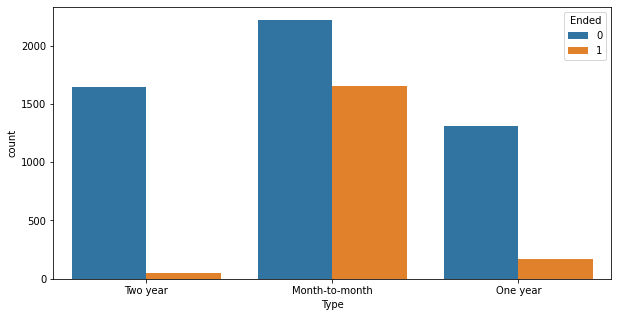

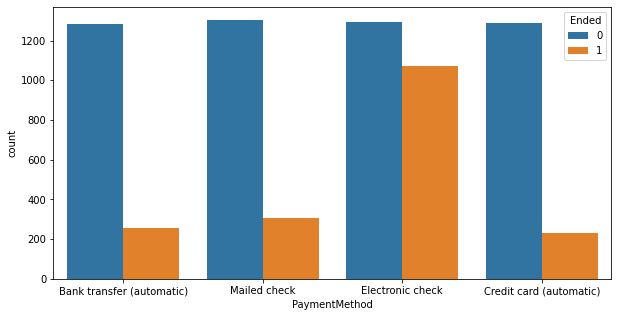

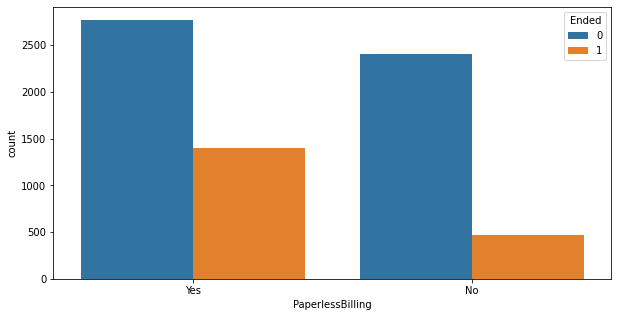

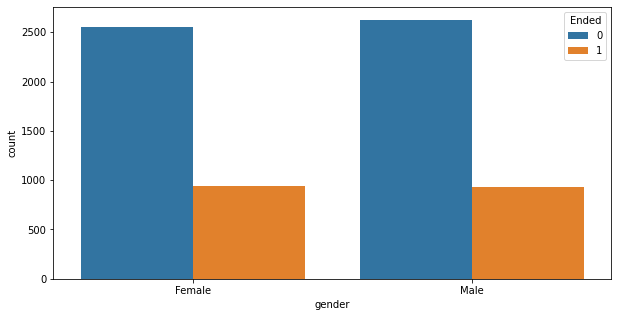

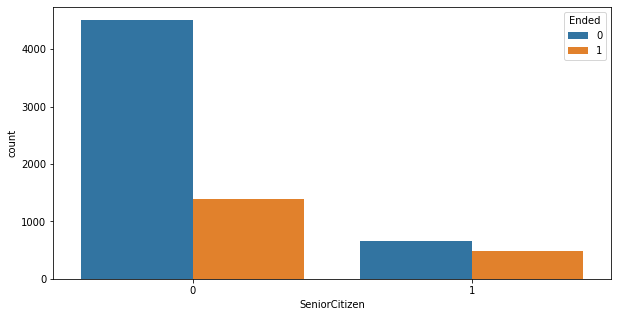

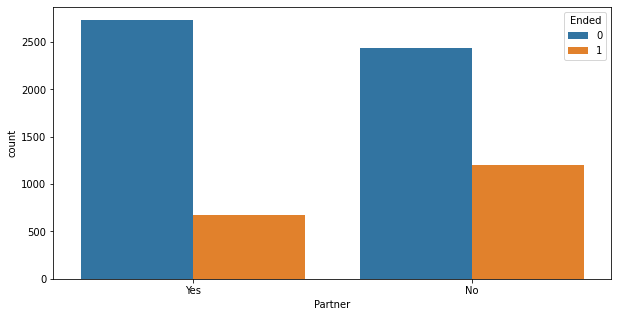

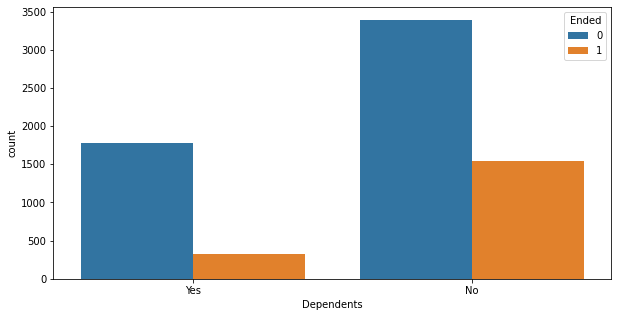

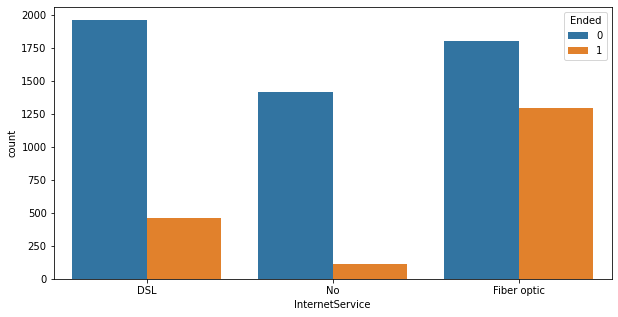

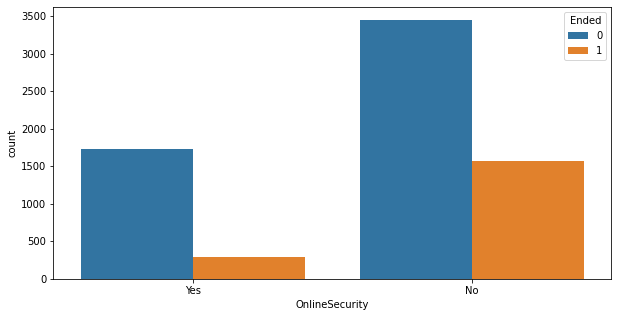

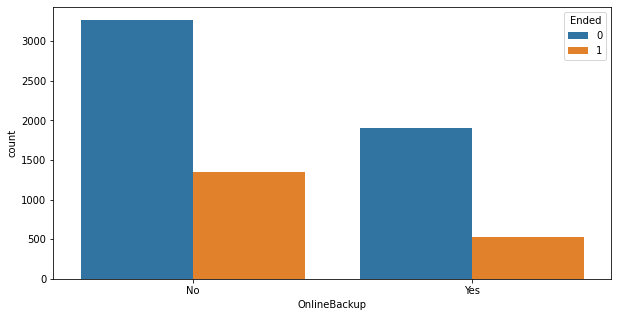

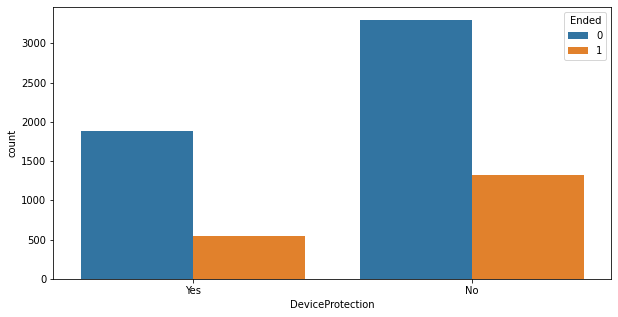

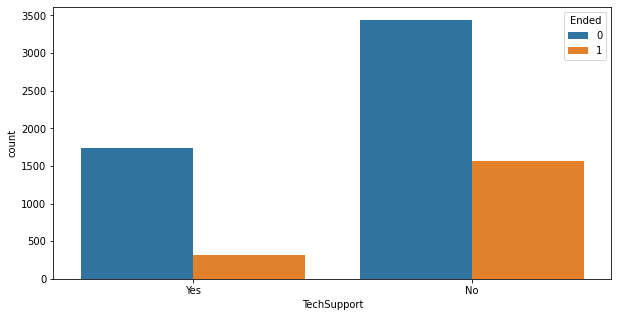

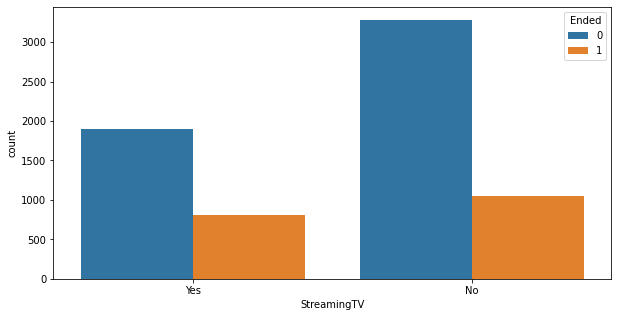

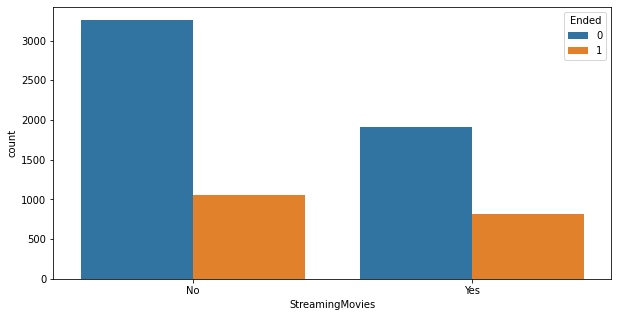

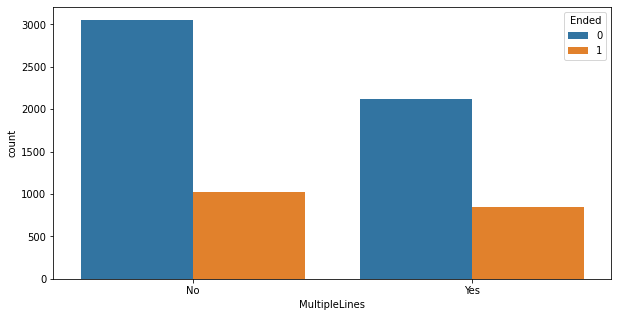

In [71]:
column_list=['Type','PaymentMethod','PaperlessBilling','gender','SeniorCitizen','Partner','Dependents','InternetService',
            'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']
bar_plot(full_data, column_list)

Можем выделить признаки `Type` и `PaymentMethod`, точно будем использовать их

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Ended', 'SeniorCitizen', 'DateDiff']


<AxesSubplot:>

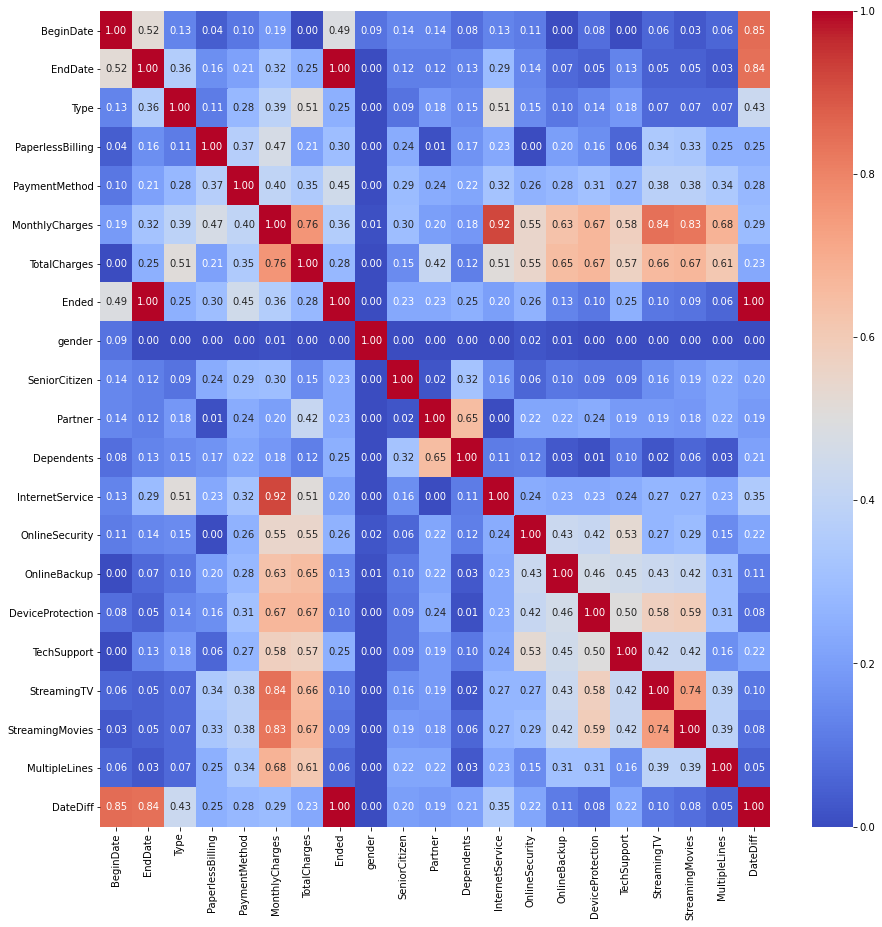

In [72]:
plt.figure(figsize=(15,15))
sns.heatmap(phik_matrix(full_data.drop('customerID', axis=1)).round(2),cmap="coolwarm", annot=True, fmt=".2f", vmin=0, vmax=1)

Созданный нами признак `DateDiff` слишком сильно коррелирует, поэтому не станем его использовать, создадим признак с датой подписания контракта

In [73]:
full_data['YearStart'] = full_data.apply(lambda row:  row['BeginDate'].year, axis=1)
full_data['YearStart']

0       2020
1       2020
2       2018
3       2020
4       2019
        ... 
7038    2019
7039    2019
7040    2019
7041    2019
7042    2019
Name: YearStart, Length: 7043, dtype: int64

Провели анализ наших датафреймов на аномалии, пропуски и другие проблемы. Избавились от пропусков, попробовали создать новые признаки для обучения. Объединили данные в один датафрейм для обучения. С помощью графиков, мы выделили сильно коррелирующие признаки: `Type` и `PaymentMethod`

## Подготовим данные для обучения

In [74]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   Ended             7043 non-null   int64  
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 non-null   object 


In [75]:
features = full_data.drop(['customerID','BeginDate','EndDate','Ended','DateDiff'], axis=1)
target = full_data['Ended']
print(features.shape)
print(target.shape)

(7043, 18)
(7043,)


In [76]:
cat = ['Type','PaymentMethod','PaperlessBilling','gender','SeniorCitizen','Partner','Dependents','InternetService',
            'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']
num = ['MonthlyCharges','TotalCharges','YearStart']

In [77]:
features_train, features_test, target_train, target_test = train_test_split( 
        features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [78]:
col_transformer = ColumnTransformer(
                    transformers=[
                        ('ss', StandardScaler(), num),
                        ('ohe', OneHotEncoder(drop='first', sparse=False), cat)
                    ],
                    remainder='drop',
                    n_jobs=-1
                    )

In [79]:
features_train_ohe = col_transformer.fit_transform(features_train)
features_test_ohe = col_transformer.transform(features_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [80]:
features_new= pd.DataFrame(features_train_ohe,columns=col_transformer.get_feature_names_out())

In [81]:
features_new

,ss__MonthlyCharges,ss__TotalCharges,ss__YearStart,ohe__Type_One year,ohe__Type_Two year,ohe__PaymentMethod_Credit card (automatic),ohe__PaymentMethod_Electronic check,ohe__PaymentMethod_Mailed check,ohe__PaperlessBilling_Yes,ohe__gender_Male,...,ohe__Dependents_Yes,ohe__InternetService_Fiber optic,ohe__InternetService_No,ohe__OnlineSecurity_Yes,ohe__OnlineBackup_Yes,ohe__DeviceProtection_Yes,ohe__TechSupport_Yes,ohe__StreamingTV_Yes,ohe__StreamingMovies_Yes,ohe__MultipleLines_Yes
0,0.198237,1.200065,0.492882,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0.542055,1.251644,0.492882,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2,-1.485805,-0.375263,0.492882,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.494407,0.313436,0.492882,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,-1.330586,-0.897827,0.492882,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,1.620243,1.016481,-1.981835,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5278,0.343442,-0.972554,0.492882,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5279,0.607147,-0.870145,0.492882,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5280,1.019395,-0.321088,0.492882,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


In [82]:
print(features_train_ohe.shape, target_train.shape)
print(features_test_ohe.shape, target_test.shape)

(5282, 22) (5282,)
(1761, 22) (1761,)


Наши данные готовы к обучению

## Обучим модель

### 1.RandomForestClassifier

In [83]:
param_grid_ = { # словарь параетров
    'max_depth':[5,7,9,11,13,15,17,19,20],
    'min_samples_leaf':[2,4,6,8,10,15,20],    
    'n_estimators': [10, 20, 30, 40, 50,100],
    'max_features': ['log2'],    
    'criterion' : ['gini']
}

In [84]:
%%time
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
grid_CV_rfc = GridSearchCV(estimator=rfc,
                       param_grid=param_grid_,
                       cv=5,
                       scoring='roc_auc'
                       #scoring='accuracy'
)
grid_CV_rfc.fit(features_train_ohe, target_train)
#preds_rfc = grid_CV_rfc.best_estimator_.predict(X_train)
print(grid_CV_rfc.best_score_)

0.8744239239777022
CPU times: user 5min 26s, sys: 1.88 s, total: 5min 28s
Wall time: 5min 34s


### 2.CatBoostClassifier

In [85]:
param_grid_cbc = { # словарь параетров
    'depth':[5,7,9,11],
    'iterations': [150,300],
    'learning_rate':[1e-3,1e-2,0.1,1e-4]
}

In [86]:
train, catboost_test, train_t, test_t = train_test_split(features,target,test_size=0.25,shuffle=True,random_state=RANDOM_STATE)

In [87]:
%%time
cbc = CatBoostClassifier(cat_features=cat,random_seed=42,verbose=False)

grid_CV_cbc = GridSearchCV(estimator=cbc,
                       param_grid=param_grid_cbc,
                       cv=5,
                       scoring='roc_auc'
)
grid_CV_cbc.fit(train, train_t)
print(grid_CV_cbc.best_score_)

0.8752134226924839
CPU times: user 8min 49s, sys: 21.6 s, total: 9min 10s
Wall time: 11min 33s


### 3.Neural Net

In [88]:
features_train_nn, features_val, target_train_nn, target_val = train_test_split( 
        features_train_ohe, target_train, test_size=0.3, random_state=RANDOM_STATE
)

In [89]:
X_train = torch.FloatTensor(features_train_nn)
X_test = torch.FloatTensor(features_test_ohe)
X_val = torch.FloatTensor(features_val)
y_train = torch.FloatTensor(target_train_nn.to_numpy())
y_test = torch.FloatTensor(target_test.to_numpy())
y_val = torch.FloatTensor(target_val.to_numpy())


In [90]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True,
                               num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=32, num_workers=0)

In [91]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
                 n_hidden_neurons_4, n_out_neurons,p_value_1, p_value_2):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.Sigmoid()
            self.dp1 = nn.Dropout(p=p_value_1)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)            
            self.act2 = nn.Sigmoid()
            self.dp2 = nn.Dropout(p=p_value_2)
            self.fc3 = nn.Linear(n_hidden_neurons_2,n_hidden_neurons_3)            
            self.act3 = nn.Sigmoid()
            self.dp3 = nn.Dropout(p=p_value_1)
            self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
            self.act4 = nn.Sigmoid()
            self.dp4 = nn.Dropout(p=p_value_2)
            self.fc5 = nn.Linear(n_hidden_neurons_4, n_out_neurons)  
            
    def forward(self, x):
        x = self.fc1(x)        
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.dp3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.dp4(x)
        x = self.fc5(x)
        x = nn.Sigmoid()(x)  # добавляем Sigmoid активацию для ограничения выхода от 0 до 1
        
        return x


In [92]:
n_in_neurons = 22
n_hidden_neurons_1 = 70
n_hidden_neurons_2 = 35
n_hidden_neurons_3 = 80
n_hidden_neurons_4 = 25
n_out_neurons = 1
p_value_1 = 0.2
p_value_2 = 0.5

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2,n_hidden_neurons_3, n_hidden_neurons_4, n_out_neurons,p_value_1, p_value_2)
optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-3)
optimizer4 = torch.optim.Adamax(net.parameters(), lr=1e-4)
optimizer5 = torch.optim.Adam(net.parameters(), lr=1e-3)

optimizers = [optimizer1, optimizer1, optimizer3, optimizer4, optimizer5]

loss = nn.BCELoss() 

In [93]:
history=[]
num_epochs = 100
batch_size = 40
num_batches = math.ceil(len(X_train)/batch_size)

for optimizer in optimizers:
    optimizer_auc = []
    print(f'Оптимизатор {optimizer}:')

    for epoch in range(num_epochs):
        
        order = np.random.permutation(len(X_train))
        
        for batch_idx in range(num_batches):
            
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index : start_index + batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch.float()).flatten()

            loss_value = loss(preds, y_batch)            

            loss_value.backward()

            optimizer.step()

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            net.eval()
            val_preds = net.forward(X_val.float()).flatten()
            auc = roc_auc_score(y_val, val_preds.detach().numpy())
            print(f'Метрика roc_auc на {epoch} итерации =', auc)
            optimizer_auc.append(auc)
    print()
    print(f'Лучшая метрика roc_auc = {max(optimizer_auc)} обнаружена на {optimizer_auc.index(max(optimizer_auc))} эпохе')
    history.append(max(optimizer_auc))
    print(f'Средняя метрика roc_auc = {round(np.mean(optimizer_auc), 2)}')
    print('---------------------------------------------------------------------------------------------', '\n')


Оптимизатор Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
):
Метрика roc_auc на 0 итерации = 0.6411614034659407
Метрика roc_auc на 10 итерации = 0.8604397325878997
Метрика roc_auc на 20 итерации = 0.8633012292330415
Метрика roc_auc на 30 итерации = 0.8691564637475943
Метрика roc_auc на 40 итерации = 0.8703934278146018
Метрика roc_auc на 50 итерации = 0.8705602552052181
Метрика roc_auc на 60 итерации = 0.8704951518332703
Метрика roc_auc на 70 итерации = 0.8703852898931084
Метрика roc_auc на 80 итерации = 0.8702408417865993
Метрика roc_auc на 90 итерации = 0.8701065660819571
Метрика roc_auc на 99 итерации = 0.8700577385529962

Лучшая метрика roc_auc = 0.8705602552052181 обнаружена на 5 эпохе
Средняя метрика roc_auc = 0.85
--------------------------------------------------------------------------------------------- 

Оптимизатор Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr:

In [94]:
print(f'Лучшая метрика roc_auc = {max(history)}')

Лучшая метрика roc_auc = 0.8755182838751155


## Тестирование лучшей модели

Лучше всего себя проявила нейронная сеть, протестируем её

In [95]:
test_preds = net.forward(X_test.float()).flatten()
print(f'Значение метрики roc_auc = {roc_auc_score(y_test, test_preds.detach().numpy())}')
print(f'Значение метрики accuracy = {accuracy_score(y_test, (test_preds.detach().numpy() > 0.5).astype(int))}')

Значение метрики roc_auc = 0.86917589526698
Значение метрики accuracy = 0.8160136286201022


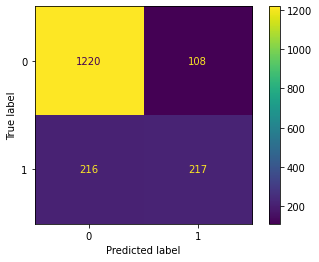

Полнота 0.5011547344110855
Точность 0.6676923076923077


In [96]:
cm = confusion_matrix(y_test, (test_preds.detach().numpy() > 0.5).astype(int), labels=grid_CV_rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_CV_rfc.best_estimator_.classes_)
disp.plot()
plt.show()
print('Полнота', recall_score(y_test, (test_preds.detach().numpy() > 0.5).astype(int)))
print('Точность',precision_score(y_test, (test_preds.detach().numpy() > 0.5).astype(int)))

In [97]:
from sklearn.metrics import precision_recall_curve, average_precision_score

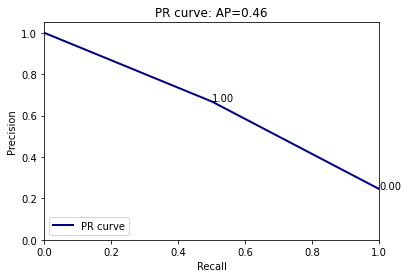

<Figure size 720x720 with 0 Axes>

In [98]:
precision, recall, thresholds = precision_recall_curve(y_test, (test_preds.detach().numpy() > 0.5).astype(int))

# Вычисление площади под PR-кривой
average_precision = average_precision_score(y_test, (test_preds.detach().numpy() > 0.5).astype(int))

# Вывод PR-кривой
plt.plot(recall, precision, lw=2, color='navy', label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

# Вывод значений точности и полноты на график
for i, value in enumerate(thresholds):
    plt.text(recall[i], precision[i], '%.2f' % value)
plt.figure(figsize=(10,10))
plt.show()

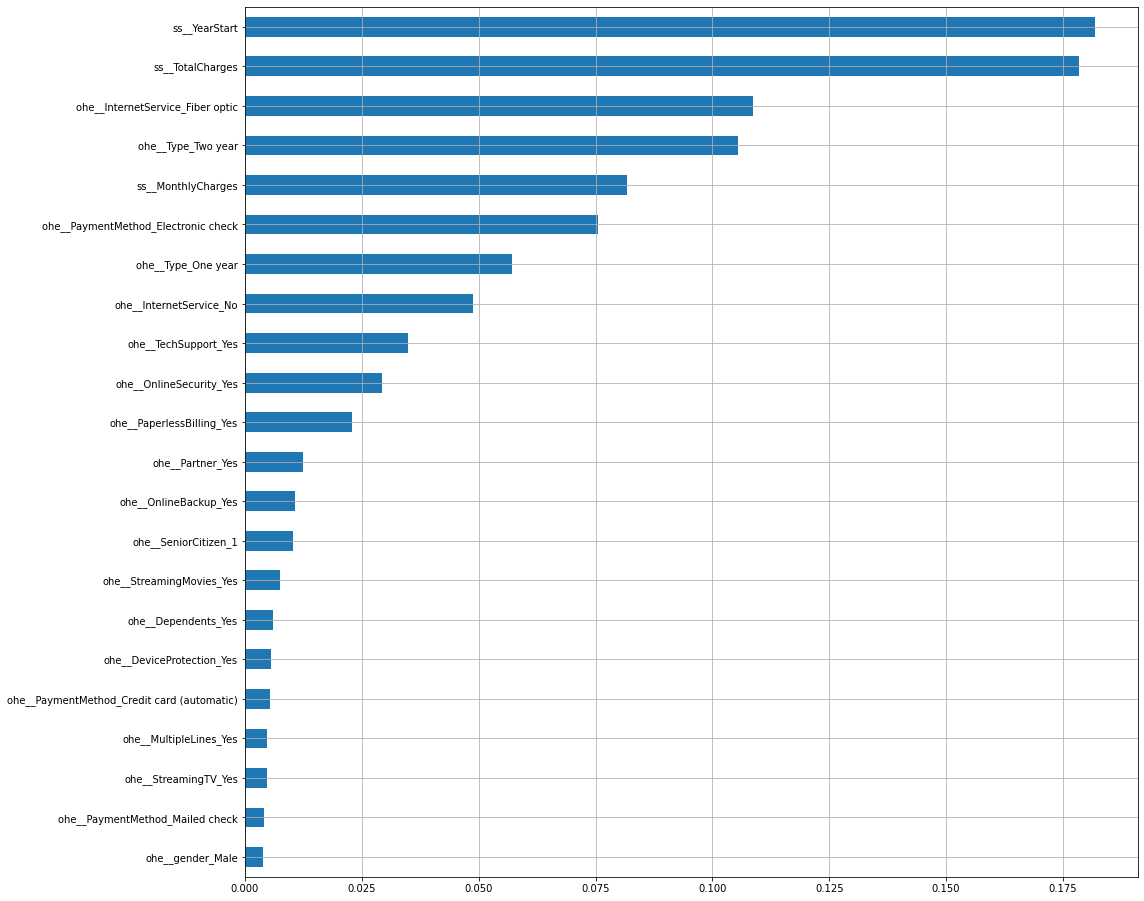

In [99]:
(pd.DataFrame(data={'score': grid_CV_rfc.best_estimator_.feature_importances_}, 
                      index=features_new.columns).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(16,16), legend=False));

Как мы и отметили раннее, признаки `Type` и `PaymentMethod` оказались важными, так же сильно выделяется признак `TotalCharges`, что неудивительно, оценим его

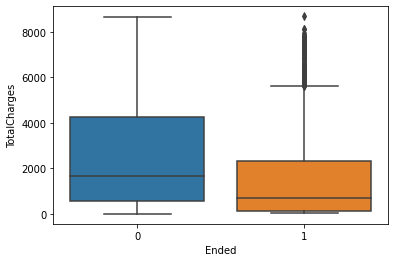

In [100]:
sns.boxplot(x='Ended', y='TotalCharges', data=full_data)
plt.show()

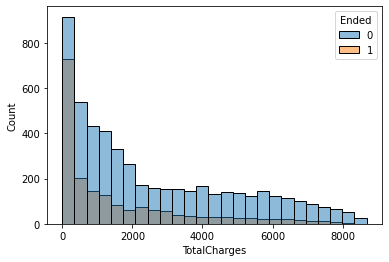

In [101]:
import seaborn as sns

sns.histplot(x='TotalCharges', hue='Ended', data=full_data)
plt.show()


Мы видим, что вопреки ожиданиям, больше всего уходяд клиенты тратящие немного. Оценим еще раз признак `Type`

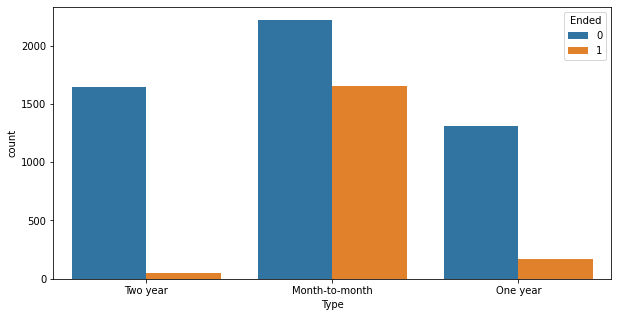

In [102]:
bar_plot(full_data, ['Type'])

Видим, что большее число ушедших, было на помесячной оплате

Так же посмотрим признак `PaymentMethod`

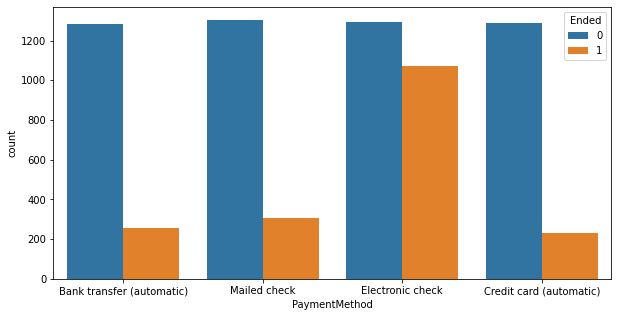

In [103]:
bar_plot(full_data, ['PaymentMethod'])

Видим, что большее число ушедших, оплачивало электронно

## Выводы

В данном проекте мы сделали следующие:
- Загрузили данные
- Провели их исследовательский анализ, предположили важность признаков `Type` и `PaymentMethod`
- Подготовили данные и обучили на них модель, добились значения `ROC-AUC` = 0.869 на тестовых данных, и достаточно высокую `accuracy` = 0.815
- Посмотрели на важность признаков, подвердили наше предположение

Бизнес-рекоммендации: 
- Видим, что пользователи, оплатившие один/два года сразу, практически не уходят, возможно стоит давать скидки при подписывании контракта на эти промежутки времени
- Так же, пользователи электронно оплачивающие, часто уходят, возможно стоит давать бонусы/скидки при выборе оплаты кредитной картой или банковским трансфером
